# Preprocessing of Mutation Frequencies
This notebook is devoted to the preprocessing of TCGA mutation frequencies. I will derive a matrix, containing the mutation frequencies per samples (columns) and genes (rows).
This matrix will later be the feature matrix used by another notebook to form a hdf5 container.

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mygene
import h5py
import os, sys, math
import umap
bestSplit = lambda x: (round(math.sqrt(x)), math.ceil(x / round(math.sqrt(x))))
plt.rc('font', family='Times New Roman')
%matplotlib inline

## Parameters
* `ULTRA_MUTATED_SAMPLES_THRESHOLD`: This value tells us how many mutations (CNAs + SNVs) a sample is allowed to have before we remove it. The reason behind this filtering step is that there are some samples with accumulated mutations that do not neccessarily contribute
* `USE_CNAS`: Use CNA information or only SNVs
* `NORMALIZE_FOR_GENE_LENGTH`: Whether dividing SNV frequencies by the length of the gene or not

In [35]:
ULTRA_MUTATED_SAMPLES_THRESHOLD = 1000
USE_CNAS = False
NORMALIZE_FOR_GENE_LENGTH = True

## Preprocessing SNVs
I downloaded one MAF file from TCGA. Those files have to be pre-processed, roughly following the data processing from HotNet2.
I decided to do the following steps:
1. Loading the MAF as `DataFrame`
2. Removing non-silent mutations (_step 2.ii in calling from HotNet2 preprocessing_)
3. Removing ultra-mutators (_step 1.i in filtering from HotNet2 preprocessing._)
4. Compute $Gene \times Sample$ matrix $S_c$ for each cancer type $c$
5. Normalize for the gene length using the [GENCODE basic annotation](ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_29/gencode.v29.basic.annotation.gff3.gz)

In [36]:
trim_fun = lambda x: '-'.join(str(x).split('-')[:4]) # TCGA barcode including sample

def get_gene_sample_matrix(path, ultra_mutators, gene_lengths=None):
    maf = pd.read_csv(path, compression='gzip', sep='\t', comment='#', header=0)
    non_silent = maf[maf.Variant_Classification != 'Silent'] # remove silent mutations
    #non_silent = maf
    print ("Removed {} (of {}) mutations because they are silent".format(maf.shape[0]-non_silent.shape[0],
                                                                         maf.shape[0]))
    non_silent.Tumor_Sample_Barcode = non_silent.Tumor_Sample_Barcode.map(trim_fun)

    # remove ultra-mutators
    ultra_mutators = pd.read_csv(ultra_mutators, header=None, names=['Tumor_IDs'])
    ultra_mutators.Tumor_IDs = ultra_mutators.Tumor_IDs.map(trim_fun)
    maf_no_ultra = non_silent[~non_silent.Tumor_Sample_Barcode.isin(ultra_mutators.Tumor_IDs)]
    print ("Left with {} SNVs after removing {} mutations in hyper-mutated samples".format(maf_no_ultra.shape[0], non_silent.shape[0]-maf_no_ultra.shape[0]))
    
    # compute gene x sample matrix
    gene_barcode_mat = maf_no_ultra.groupby(['Hugo_Symbol', 'Tumor_Sample_Barcode']).size().reset_index().rename(columns={0:'count'})
    assert ((gene_barcode_mat.pivot(index='Hugo_Symbol',
                                    columns='Tumor_Sample_Barcode',
                                    values='count'
                                   ).sum() == maf_no_ultra.groupby('Tumor_Sample_Barcode').count().Hugo_Symbol).all())
    assert ((gene_barcode_mat.pivot(index='Hugo_Symbol',
                                    columns='Tumor_Sample_Barcode',
                                    values='count'
                                   ).sum(axis=1) == maf_no_ultra.groupby('Hugo_Symbol').count().Tumor_Sample_Barcode).all())
    gene_sample_matrix = gene_barcode_mat.pivot(index='Hugo_Symbol', columns='Tumor_Sample_Barcode', values='count').replace(np.NaN, 0)
    
    # lastly, normalize for gene length if requested
    if not gene_lengths is None:
        bpmr = gene_sample_matrix.sum() / float(gene_lengths.sum()) # mutation rate per base per patient (vector)
        expected_mutation_rates = pd.DataFrame(np.matlib.repmat(bpmr, gene_lengths.shape[0], 1) * gene_lengths.values.reshape(-1, 1),
                                               index=gene_lengths.index,
                                               columns=bpmr.index
                                              ) # expected mutation frequency per gene and patient
        # normalized mutation frequency (actual mutations divided by expected mutations)
        # We add 1 to the dividend to avoid division by 0 or too much influence of short genes
        denom = 1 + expected_mutation_rates.reindex_like(gene_sample_matrix).fillna(expected_mutation_rates.median(axis=0))
        normalized_gene_sample_matrix = gene_sample_matrix / denom
        return normalized_gene_sample_matrix
    else:
        return gene_sample_matrix

Text(0.5, 1.0, '20 Longest Proteins')

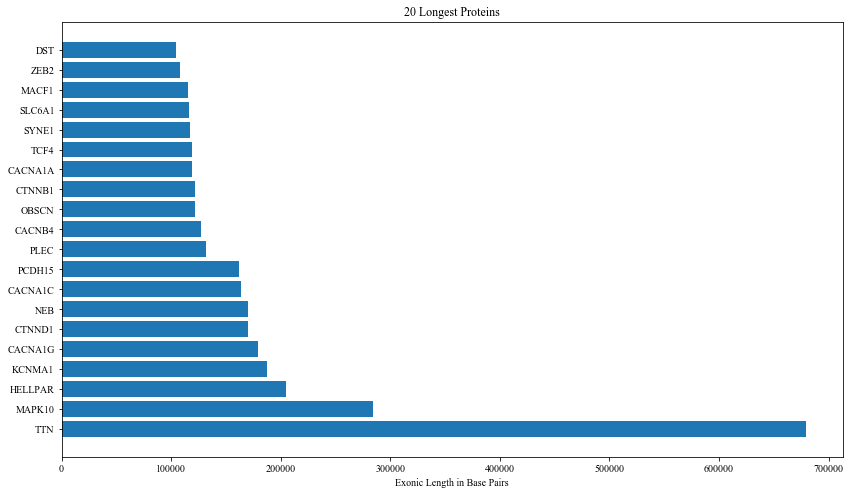

In [37]:
annotation_gencode = pd.read_csv('../../data/pancancer/gencode/gencode.v28.basic.annotation.gff3',
                                 comment='#', sep='\t', skiprows=7,header=None,
                                 names=['chr', 'source', 'type', 'start', 'end', 'score', 'strand', 'phase', 'attr']
                                )
# derive length of all exons
annotation_gencode = annotation_gencode[annotation_gencode.type == 'exon']
annotation_gencode['length'] = np.abs(annotation_gencode.end - annotation_gencode.start)
# extract the gene name for each exon
def get_hugo_symbol(row):
    s = row.attr
    for elem in s.split(';'):
        if elem.startswith('gene_name'):
            return elem.split('=')[1].strip()
    return None
annotation_gencode['Hugo_Symbol'] = annotation_gencode.apply(get_hugo_symbol, axis=1)
# add length of exons together for each gene
exonic_gene_lengths = annotation_gencode.groupby('Hugo_Symbol').length.sum()

# plot the longest proteins at the end
fig = plt.figure(figsize=(14, 8))
plt.barh(y = range(20), width=exonic_gene_lengths.sort_values(ascending=False).head(20), tick_label=exonic_gene_lengths.sort_values(ascending=False).head(20).index)
plt.xlabel('Exonic Length in Base Pairs')
plt.title('20 Longest Proteins')

In [38]:
base_dir = '../../data/pancancer/TCGA/mutation/download_new/'
ultra_mutator_file = '../../data/pancancer/TCGA/mutation/ultramutated_tumor_ids'
all_matrices = []
ctypes = []
for dname in os.listdir(base_dir):
    ctype_dir = os.path.join(base_dir, dname)
    if os.path.isdir(ctype_dir):
        for maffile in os.listdir(ctype_dir):
            if maffile.endswith('.maf.gz'):
                gene_sample_matrix = get_gene_sample_matrix(os.path.join(ctype_dir, maffile),
                                                            ultra_mutators=ultra_mutator_file,
                                                            gene_lengths=exonic_gene_lengths if NORMALIZE_FOR_GENE_LENGTH else None
                                                           )
                all_matrices.append(gene_sample_matrix)
                ctype = maffile.split('.')[1]
                print ("Processed {} with {} samples".format(ctype, gene_sample_matrix.shape[1]))
                ctypes.append(ctype)

/pkg/python-3.6.0-0/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (87,98,118) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Removed 11029 (of 64804) mutations because they are silent


/pkg/python-3.6.0-0/lib/python3.6/site-packages/pandas/core/generic.py:2773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


Left with 50113 SNVs after removing 3662 mutations in hyper-mutated samples
Processed READ with 135 samples


/pkg/python-3.6.0-0/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (87,88,98,118) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Removed 44644 (of 213144) mutations because they are silent
Left with 168500 SNVs after removing 0 mutations in hyper-mutated samples
Processed STAD with 437 samples


/pkg/python-3.6.0-0/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (87,88,118) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Removed 41350 (of 208180) mutations because they are silent
Left with 164350 SNVs after removing 2480 mutations in hyper-mutated samples
Processed LUAD with 563 samples


/pkg/python-3.6.0-0/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (19,20,28,87,88) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Removed 18759 (of 103405) mutations because they are silent
Left with 84646 SNVs after removing 0 mutations in hyper-mutated samples
Processed CESC with 289 samples


/pkg/python-3.6.0-0/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (87) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Removed 7505 (of 45313) mutations because they are silent
Left with 37808 SNVs after removing 0 mutations in hyper-mutated samples
Processed ESCA with 184 samples
Removed 150337 (of 886377) mutations because they are silent
Left with 595030 SNVs after removing 141010 mutations in hyper-mutated samples
Processed UCEC with 512 samples
Removed 22391 (of 120988) mutations because they are silent
Left with 95408 SNVs after removing 3189 mutations in hyper-mutated samples
Processed BRCA with 977 samples


/pkg/python-3.6.0-0/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (88,118) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Removed 10010 (of 54238) mutations because they are silent
Left with 44228 SNVs after removing 0 mutations in hyper-mutated samples
Processed LIHC with 364 samples
Removed 4192 (of 23765) mutations because they are silent
Left with 19573 SNVs after removing 0 mutations in hyper-mutated samples
Processed KIRP with 281 samples
Removed 50029 (of 264786) mutations because they are silent
Left with 167053 SNVs after removing 47704 mutations in hyper-mutated samples
Processed COAD with 381 samples
Removed 37375 (of 181116) mutations because they are silent
Left with 137321 SNVs after removing 6420 mutations in hyper-mutated samples
Processed LUSC with 488 samples


/pkg/python-3.6.0-0/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (87,118) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Removed 22272 (of 102309) mutations because they are silent
Left with 75872 SNVs after removing 4165 mutations in hyper-mutated samples
Processed HNSC with 504 samples


/pkg/python-3.6.0-0/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (88,98) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Removed 1519 (of 10899) mutations because they are silent
Left with 9380 SNVs after removing 0 mutations in hyper-mutated samples
Processed THCA with 491 samples
Removed 29267 (of 134513) mutations because they are silent
Left with 103792 SNVs after removing 1454 mutations in hyper-mutated samples
Processed BLCA with 411 samples
Removed 4467 (of 26693) mutations because they are silent
Left with 22226 SNVs after removing 0 mutations in hyper-mutated samples
Processed KIRC with 336 samples
Removed 6620 (of 29286) mutations because they are silent
Left with 22666 SNVs after removing 0 mutations in hyper-mutated samples
Processed PRAD with 495 samples


In [39]:
print ("Samples with mutations per Cancer Type:")
for i in range(len(all_matrices)):
    print ("{}: {} Samples".format(ctypes[i], all_matrices[i].shape))

Samples with mutations per Cancer Type:
READ: (15181, 135) Samples
STAD: (18897, 437) Samples
LUAD: (18540, 563) Samples
CESC: (18445, 289) Samples
ESCA: (14161, 184) Samples
UCEC: (21117, 512) Samples
BRCA: (18291, 977) Samples
LIHC: (14984, 364) Samples
KIRP: (10503, 281) Samples
COAD: (19304, 381) Samples
LUSC: (18316, 488) Samples
HNSC: (16939, 504) Samples
THCA: (5814, 491) Samples
BLCA: (18066, 411) Samples
KIRC: (10985, 336) Samples
PRAD: (11114, 495) Samples


In [40]:
# get the big gene x sample matrix for all cancer types
whole_gene_sample_matrix = all_matrices[0].join(all_matrices[1:], how='outer').fillna(0)
#np.save('../../data/pancancer/TCGA/mutation/gene_sample_snvs.npy', whole_gene_sample_matrix)
whole_gene_sample_matrix.shape

(21668, 6848)

In [41]:
# get the mean matrices
mean_mutations = []
for df in all_matrices:
    mean_mutations.append(df.mean(axis=1))
mean_mutation_matrix = pd.DataFrame(mean_mutations, index=ctypes).T
mean_mutation_matrix.fillna(0, inplace=True)
mean_mutation_matrix.head()

,READ,STAD,LUAD,CESC,ESCA,UCEC,BRCA,LIHC,KIRP,COAD,LUSC,HNSC,THCA,BLCA,KIRC,PRAD
A1BG,0.014768,0.018042,0.015867,0.010318,0.000000,0.050370,0.003070,0.008235,0.003556,0.028149,0.010209,0.015759,0.000000,0.019330,0.002974,0.002020
A1CF,0.009073,0.019704,0.025842,0.014170,0.000000,0.022003,0.008660,0.010204,0.000000,0.014861,0.037904,0.015977,0.000000,0.009195,0.008777,0.012484
A2M,0.072417,0.061422,0.045522,0.016192,0.021601,0.099077,0.010138,0.010957,0.010651,0.064007,0.040682,0.011606,0.002035,0.033780,0.014811,0.005739
A2ML1,0.045499,0.057340,0.041338,0.025815,0.005370,0.071714,0.010906,0.010917,0.003547,0.088186,0.040467,0.017498,0.000000,0.028382,0.005933,0.002014
A3GALT2,0.000000,0.011372,0.001762,0.006857,0.005426,0.001932,0.000000,0.000000,0.000000,0.012985,0.002047,0.000000,0.000000,0.002421,0.000000,0.000000


Text(0, 0.5, 'Mutation Frequency')

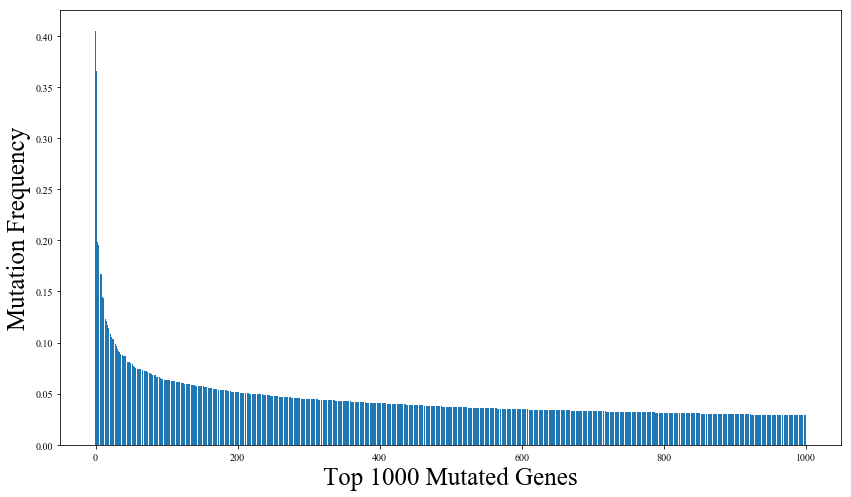

In [42]:
# quick and dirty histogram
number_to_display = 1000
x = mean_mutation_matrix.mean(axis=1).sort_values(ascending=False)
fig = plt.figure(figsize=(14, 8))
plt.bar(x=range(number_to_display), height=x[:number_to_display])
#_ = plt.hist(x, bins=np.linspace(0.0008, .2, 300))
plt.xlabel('Top {} Mutated Genes'.format(number_to_display), fontsize=25)
plt.ylabel('Mutation Frequency', fontsize=25)

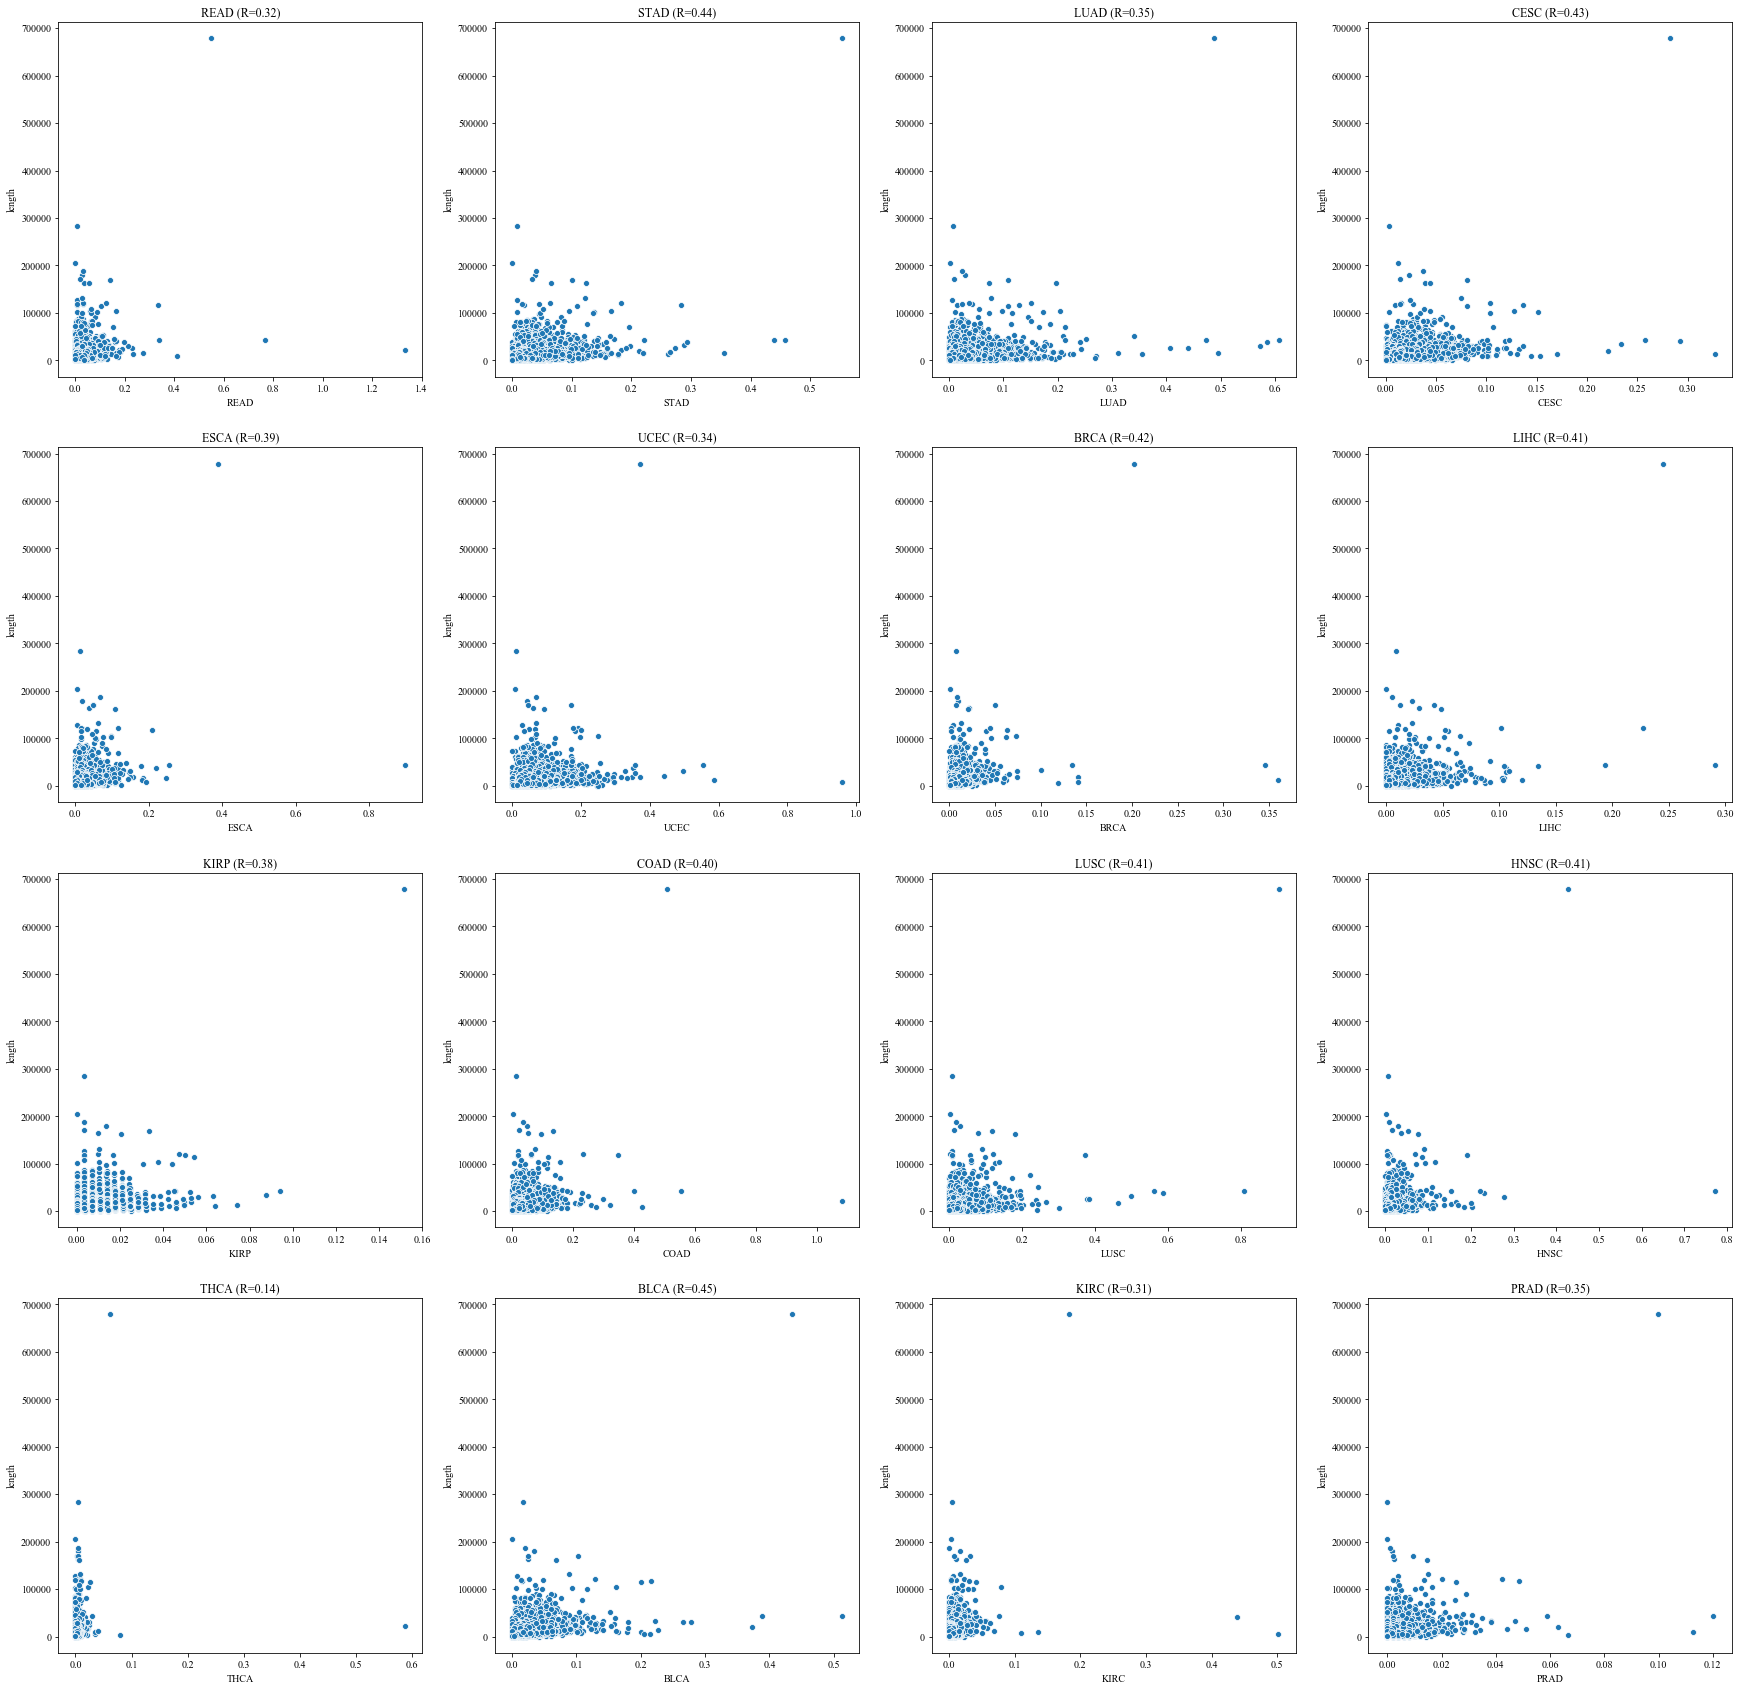

In [43]:
length_and_mean_matrix = mean_mutation_matrix.join(exonic_gene_lengths)
fig = plt.figure(figsize=(30, 30))
x, y = bestSplit(mean_mutation_matrix.shape[1])
for i in range(mean_mutation_matrix.shape[1]):
    plt.subplot(x, y, i+1)
    sns.scatterplot(length_and_mean_matrix.iloc[:, i], length_and_mean_matrix.length)
    plt.title('{0} (R={1:.2f})'.format(mean_mutation_matrix.columns[i],
                                 length_and_mean_matrix.iloc[:, i].corr(length_and_mean_matrix.length)))
#fig.savefig('../../data/pancancer/TCGA/mutation/mutation_length_correlation_raw.png', dpi=300)

In [44]:
mean_mutation_matrix.to_csv('../../data/pancancer/TCGA/mutation/gene_ctype_snvs.tsv', sep='\t')

In [45]:
whole_gene_sample_matrix.columns = whole_gene_sample_matrix.columns.map(trim_fun)
whole_gene_sample_matrix.head()

,TCGA-AF-2687-01A,TCGA-AF-2690-01A,TCGA-AF-2693-01A,TCGA-AF-3911-01A,TCGA-AF-3913-01A,TCGA-AF-3914-01A,TCGA-AF-4110-01A,TCGA-AF-5654-01A,TCGA-AF-6136-01A,TCGA-AF-6655-01A,...,TCGA-ZG-A9LN-01A,TCGA-ZG-A9LS-01A,TCGA-ZG-A9LU-01A,TCGA-ZG-A9LY-01A,TCGA-ZG-A9LZ-01A,TCGA-ZG-A9M4-01A,TCGA-ZG-A9MC-01A,TCGA-ZG-A9N3-01A,TCGA-ZG-A9ND-01A,TCGA-ZG-A9NI-01A
A1BG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1CF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2M,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2ML1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A3GALT2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Preprocessing CNAs
This section loads the CNA mean matrix computed by `preprocess_cnas.ipynb` and incorporates that additional information into our model.
The CNAs are also preprocessed a little. This involves the following steps:
1. Load the CNA files
2. Remove ultra-mutated samples

In [46]:
# load CNAs
cna_sample_matrix = pd.read_csv('../../data/pancancer/TCGA/mutation/firehose_cnas_sample_20160128.tsv')
cna_sample_matrix.rename(columns={'Unnamed: 0':'Name'}, inplace=True)
cna_sample_matrix.set_index('Name', inplace=True)
cna_sample_matrix.columns = cna_sample_matrix.columns.map(trim_fun)

cna_mean_matrix = pd.read_csv('../../data/pancancer/TCGA/mutation/firehose_cnas_meancancertypes_20160128.tsv', sep='\t')
cna_mean_matrix.rename(columns={'Unnamed: 0':'Name'}, inplace=True)
cna_mean_matrix.set_index('Name', inplace=True)

cna_sample_matrix.head()

,TCGA-05-4244-01A,TCGA-05-4249-01A,TCGA-05-4250-01A,TCGA-05-4382-01A,TCGA-05-4384-01A,TCGA-05-4389-01A,TCGA-05-4390-01A,TCGA-05-4395-01A,TCGA-05-4396-01A,TCGA-05-4397-01A,...,TCGA-ZP-A9D1-01A,TCGA-ZP-A9D2-01A,TCGA-ZP-A9D4-01A,TCGA-ZQ-A9CR-01A,TCGA-ZR-A9CJ-01B,TCGA-ZS-A9CD-01A,TCGA-ZS-A9CE-01A,TCGA-ZS-A9CF-01A,TCGA-ZS-A9CG-01A,TCGA-ZX-AA5X-01A
Name,,,,,,,,,,,,,,,,,,,,,
7SK,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1BG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1CF,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A2M,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A2ML1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
print ("Found {} samples in MAF files".format(whole_gene_sample_matrix.shape[1]))
print ("Found {} samples in CNA file".format(cna_sample_matrix.shape[1]))
samples_in_both = whole_gene_sample_matrix.columns.isin(cna_sample_matrix.columns).sum()
print ("Found {} samples in both, CNA and MAF".format(samples_in_both))

Found 6848 samples in MAF files
Found 7279 samples in CNA file
Found 6709 samples in both, CNA and MAF


In [48]:
# remove CNAs for ultra-mutated samples
ultra_mutators = pd.read_csv('../../data/pancancer/TCGA/mutation/ultramutated_tumor_ids', header=None, names=['Tumor_IDs'])
ultra_mutators.Tumor_IDs = ultra_mutators.Tumor_IDs.map(trim_fun)
cna_sample_matrix_no_ultra = cna_sample_matrix.loc[:, ~cna_sample_matrix.columns.isin(ultra_mutators.Tumor_IDs)]
print ("Removed {} CNA samples that belong to ultra-mutated samples".format(cna_sample_matrix.shape[1] - cna_sample_matrix_no_ultra.shape[1]))

Removed 68 CNA samples that belong to ultra-mutated samples


## Preprocess both together
As next step, let's **remove samples that have a very high number of mutations when adding CNAs and SNVs** and afterwords **remove all samples that only have CNAs but no SNVs.**

In [49]:
snvs_per_sample = whole_gene_sample_matrix.sum(axis=0)
mut_counts = cna_sample_matrix_no_ultra.sum(axis=0) + snvs_per_sample
mut_counts.fillna(0, inplace=True)
mut_counts = pd.DataFrame(mut_counts, columns=['num_mutations'])
mut_counts = mut_counts.groupby(mut_counts.index).sum() # sum duplicate samples
samples_with_many_mutations = mut_counts[mut_counts.num_mutations > ULTRA_MUTATED_SAMPLES_THRESHOLD]
print ("Removing {} samples because they have more than {} CNAs + SNVs".format(samples_with_many_mutations.shape[0], ULTRA_MUTATED_SAMPLES_THRESHOLD))

cna_sample_matrix_filtered = cna_sample_matrix_no_ultra.loc[:, ~cna_sample_matrix_no_ultra.columns.isin(samples_with_many_mutations.index)]
print ("--> {} samples with CNAs left".format(cna_sample_matrix_filtered.shape[1]))
snv_gene_sample_matrix = whole_gene_sample_matrix.loc[:,~whole_gene_sample_matrix.columns.isin(samples_with_many_mutations.index)]
print ("--> {} samples with SNVs left".format(snv_gene_sample_matrix.shape[1]))

Removing 286 samples because they have more than 1000 CNAs + SNVs
--> 6925 samples with CNAs left
--> 6562 samples with SNVs left


In [50]:
# remove CNAs that have no SNVs
final_cna_matrix = cna_sample_matrix_filtered.loc[:, cna_sample_matrix_filtered.columns.isin(snv_gene_sample_matrix.columns)]
print ("Removed {} samples with CNAs because they had no SNVs".format(cna_sample_matrix_filtered.shape[1] - final_cna_matrix.shape[1]))
print ("--> {} CNA samples left".format(final_cna_matrix.shape[1]))

Removed 502 samples with CNAs because they had no SNVs
--> 6423 CNA samples left


In [51]:
# put the two matrices together by appending them, replacing NAs with 0 and then summing the genes present in both, CNA and SNV
# I have to make sure that the columns of both matrices are in the same order. Do that by indexing
cna_mat_reindexed = final_cna_matrix.reindex(columns=snv_gene_sample_matrix.columns).dropna(axis=1)
assert ((snv_gene_sample_matrix.loc[:, snv_gene_sample_matrix.columns.isin(final_cna_matrix.columns)].columns == cna_mat_reindexed.columns).all())
cna_snv_sample_mat = snv_gene_sample_matrix.append(cna_mat_reindexed)
cna_snv_sample_mat.fillna(0, inplace=True)
cna_snv_sample_mat = cna_snv_sample_mat.groupby(cna_snv_sample_mat.index).sum()
cna_snv_sample_mat.shape, snv_gene_sample_matrix.index.isin(final_cna_matrix.index).sum()

((25826, 6562), 17788)

## Plot distributions
We now have obtained two gene-sample matrices $S_{SNV} \in \mathbb{R}^{N \times M_1}$ and $S_{CNA} \in \mathbb{R}^{N \times M_2}$, containing mutation frequencies for genes $N$ per sample ($M_1$ for SNVs and $M_2$ for CNAs).

Next, I want to plot some distributions and add the two together.

Text(0.5, 0, 'Mutation Frequency')

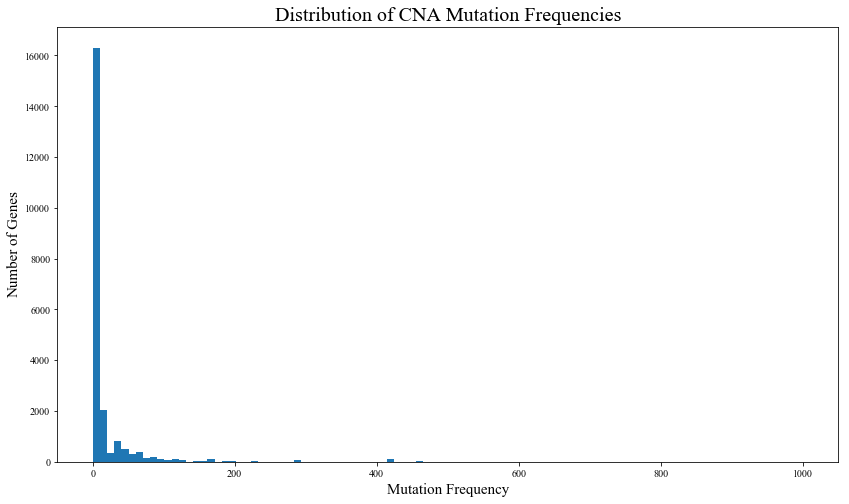

In [52]:
ax = final_cna_matrix.sum(axis=1).plot('hist', bins=np.linspace(0, 1000, 100), figsize=(14, 8))
ax.set_ylabel('Number of Genes', fontsize=15)
ax.set_title('Distribution of CNA Mutation Frequencies', fontsize=20)
ax.set_xlabel('Mutation Frequency', fontsize=15)

Text(0.5, 0, 'Number of Mutations')

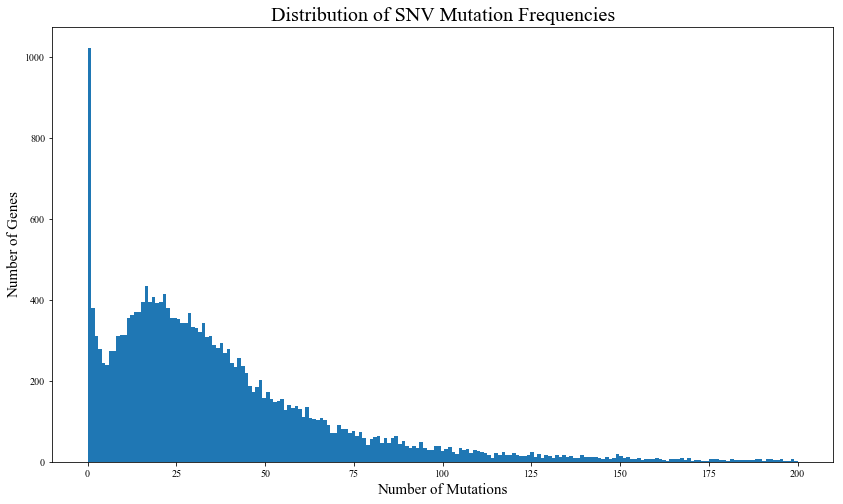

In [53]:
ax = snv_gene_sample_matrix.sum(axis=1).plot('hist', bins=np.linspace(0, 200, 200), figsize=(14, 8))
ax.set_ylabel('Number of Genes', fontsize=15)
ax.set_title('Distribution of SNV Mutation Frequencies', fontsize=20)
ax.set_xlabel('Number of Mutations', fontsize=15)

Number of genes in joint matrix: 25826


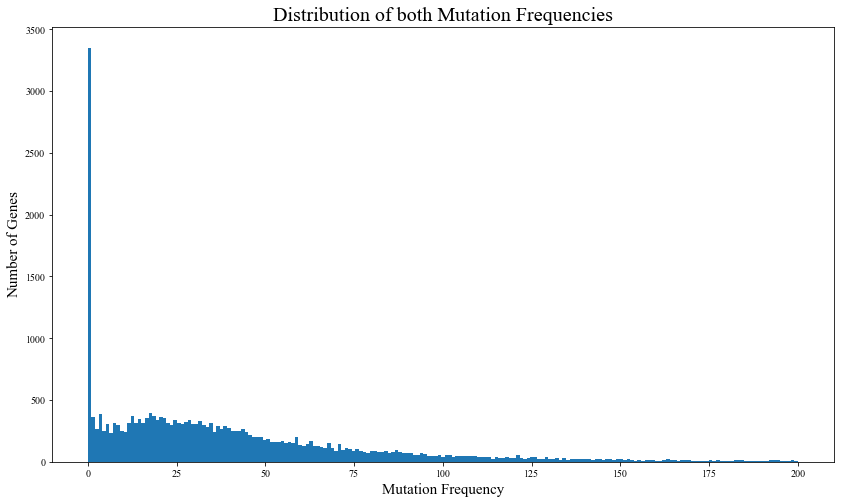

In [54]:
ax = cna_snv_sample_mat.sum(axis=1).plot('hist', bins=np.linspace(0, 200, 200), figsize=(14, 8))
ax.set_ylabel('Number of Genes', fontsize=15)
ax.set_title('Distribution of both Mutation Frequencies', fontsize=20)
ax.set_xlabel('Mutation Frequency', fontsize=15)
print ("Number of genes in joint matrix: {}".format(cna_snv_sample_mat.shape[0]))

In [55]:
if USE_CNAS:
    final_matrix = cna_snv_sample_mat
else:
    final_matrix = snv_gene_sample_matrix

## Convert Gene Names to Ensembl IDs
I finally have one big gene $\times$ sample matrix. I next want to get ensembl IDs for each of the genes to be able to compare with nodes in the networks afterwards.

In [56]:
# use mygene to get ensembl IDs from Hugo Symbols
mg = mygene.MyGeneInfo()
res = mg.querymany(final_matrix.index,
                   scopes='symbol',
                   fields='ensembl.gene, symbol',
                   species='human', returnall=True
                  )

# now, retrieve the names and IDs from a dictionary and put in DF
def get_name_and_id(x):
    ens_id = x['ensembl'][0]['gene'] if type(x['ensembl']) is list else x['ensembl']['gene']
    name = x['symbol']
    query = x['query']
    if not name == query:
        print ("Error: ", name, query)
    return [ens_id, name]

ens_ids = [get_name_and_id(x) for x in res['out'] if 'ensembl' in x]
mapping = pd.DataFrame(ens_ids, columns=['Ensembl_ID', 'Name'])
mapping.set_index('Name', inplace=True)
mapping = mapping[~mapping.index.duplicated(keep='first')]

# join mutation frequencies with our derived mapping
mut_freq_sample = final_matrix.join(mapping)
print ("{} (of {}) genes had no mapping Ensembl ID".format(mut_freq_sample.Ensembl_ID.isnull().sum(),
                                                           mut_freq_sample.shape[0]))
mut_freq_sample.dropna(inplace=True) # remove unmapped genes simply

# make Ensembl ID the index and move Hugo Symbols to column
mut_freq_sample['Name'] = mut_freq_sample.index
mut_freq_sample.set_index('Ensembl_ID', inplace=True)

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-18000...done.
querying 18001-19000...done.
querying 19001-20000...done.
querying 20001-21000...done.
querying 21001-21668...done.
Finished.
1764 input query terms found dup hits:
	[('AACSP1', 2), ('AADACL2-AS1', 3), ('AATBC', 2), ('ABCA17P', 2), ('ABCC13', 2), ('ABCC6P1', 2), ('A
1574 input query terms found no hit:
	['AAED1', 'AATK-AS1', 'AC000036.4', 'AC002519.6', 'AC003002.6', 'AC004076.7', 'AC004076.9', 'AC00415
1615 (of 21668) genes had no mapping Ensembl ID


In [57]:
mut_freq_sample.drop('Name', axis=1).sum().sum()

860545.2044613637

## Mean across cancer types & write to file
Finally, I want to compute the mean mutation frequency per cancer type and write the resulting $Gene \times Ctype$ matrix to a _csv_ file.

In [58]:
submitter_project_mapping = pd.read_json('../../data/pancancer/TCGA/mutation/download_new/cases_all_cancers.2018-11-26.json')
submitter_project_mapping.head()
submitter_project_mapping['Cancer_Type'] = [dict(i)['project_id'] for i in submitter_project_mapping.project]
submitter_project_mapping = submitter_project_mapping[['submitter_id', 'Cancer_Type']].set_index('submitter_id')
submitter_project_mapping.head()

trim_to_submitter = lambda x: '-'.join(str(x).split('-')[:3]) # TCGA barcode until patient
mut_freq_sample.columns = mut_freq_sample.columns.map(trim_to_submitter)
mut_freq_sample.head()

,TCGA-AF-2687,TCGA-AF-2690,TCGA-AF-2693,TCGA-AF-3911,TCGA-AF-3913,TCGA-AF-3914,TCGA-AF-4110,TCGA-AF-5654,TCGA-AF-6136,TCGA-AF-6655,...,TCGA-ZG-A9LS,TCGA-ZG-A9LU,TCGA-ZG-A9LY,TCGA-ZG-A9LZ,TCGA-ZG-A9M4,TCGA-ZG-A9MC,TCGA-ZG-A9N3,TCGA-ZG-A9ND,TCGA-ZG-A9NI,Name
Ensembl_ID,,,,,,,,,,,,,,,,,,,,,
ENSG00000121410,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A1BG
ENSG00000148584,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A1CF
ENSG00000175899,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A2M
ENSG00000166535,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A2ML1
ENSG00000184389,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A3GALT2


In [59]:
# join with mapping and compute the mean across cancer types
no_names = mut_freq_sample.drop('Name', axis=1)
matrix_with_cancer_types = no_names.T.join(submitter_project_mapping)
mean_mut_freqs = matrix_with_cancer_types.groupby('Cancer_Type').mean().T
print (mean_mut_freqs.sum().sum())
mean_mut_freqs.columns = [i.split('-')[1] for i in mean_mut_freqs.columns]

# get back the gene names
assert((mean_mut_freqs.index == mut_freq_sample.index).all())
mean_mut_freqs['Name'] = mut_freq_sample.Name

# write to disk
mean_mut_freqs.to_csv('../../data/pancancer/TCGA/mutation/mutfreq_mean_exonormnopllus1.tsv', sep='\t')

mean_mut_freqs.head()

2165.0932189606183


,BLCA,BRCA,CESC,COAD,ESCA,HNSC,KIRC,KIRP,LIHC,LUAD,LUSC,PRAD,READ,STAD,THCA,UCEC,Name
ENSG00000121410,0.017447,0.003098,0.007183,0.006088,0.000000,0.013855,0.002983,0.003595,0.008304,0.009220,0.008315,0.002028,0.015698,0.010350,0.000000,0.004807,A1BG
ENSG00000148584,0.009448,0.007946,0.013042,0.000000,0.000000,0.014833,0.008804,0.000000,0.008156,0.022783,0.033859,0.010060,0.007685,0.019192,0.000000,0.006390,A1CF
ENSG00000175899,0.029852,0.008231,0.010744,0.024255,0.021959,0.009782,0.014855,0.010766,0.011048,0.040280,0.041360,0.004014,0.031392,0.035996,0.002035,0.011965,A2M
ENSG00000166535,0.027043,0.010189,0.021357,0.042168,0.005459,0.015784,0.005951,0.003586,0.011008,0.030841,0.041142,0.002022,0.007838,0.035558,0.000000,0.016568,A2ML1
ENSG00000184389,0.002488,0.000000,0.003569,0.000000,0.005516,0.000000,0.000000,0.000000,0.000000,0.000000,0.002081,0.000000,0.000000,0.005169,0.000000,0.000000,A3GALT2


In [60]:
t = mean_mut_freqs.set_index('Name')
t[t.index == 'TP53']

,BLCA,BRCA,CESC,COAD,ESCA,HNSC,KIRC,KIRP,LIHC,LUAD,LUSC,PRAD,READ,STAD,THCA,UCEC
Name,,,,,,,,,,,,,,,,
TP53,0.513705,0.346962,0.073976,0.597846,0.903954,0.773994,0.023226,0.017707,0.290913,0.463205,0.81079,0.120697,0.780415,0.484419,0.004044,0.39205


In [61]:
mean_mut_freqs.set_index('Name').idxmax()

BLCA      TP53
BRCA    PIK3CA
CESC    PIK3CA
COAD       APC
ESCA      TP53
HNSC      TP53
KIRC       VHL
KIRP       TTN
LIHC      TP53
LUAD     MUC16
LUSC       TTN
PRAD      TP53
READ       APC
STAD       TTN
THCA      BRAF
UCEC      PTEN
dtype: object

## Plot information on the collected mutation frequencies

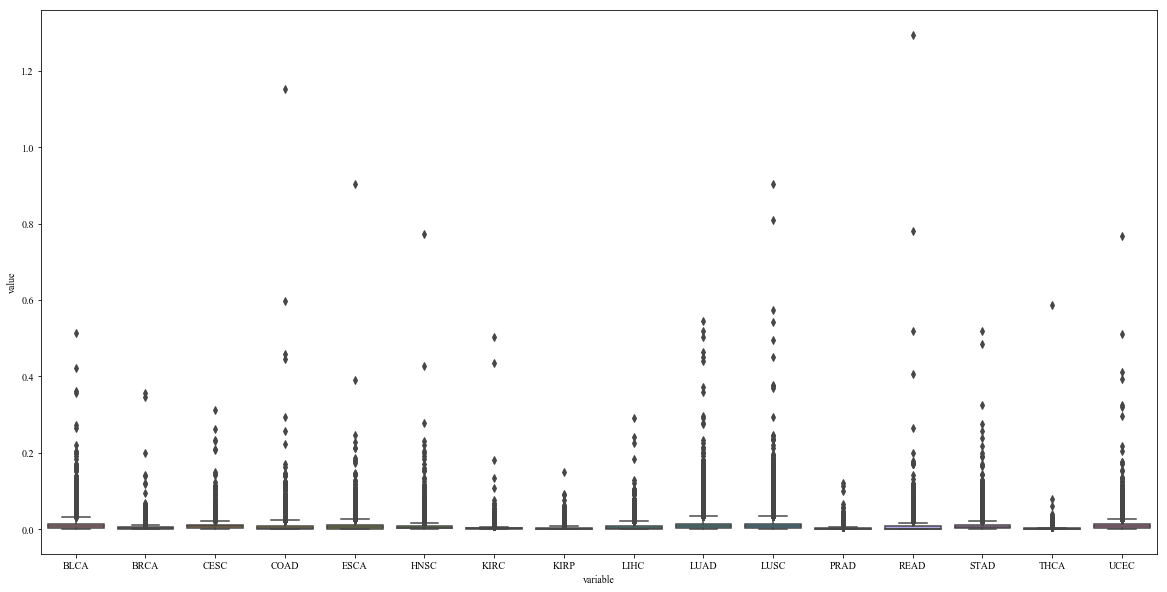

In [62]:
fig = plt.figure(figsize=(20, 10))
sns.boxplot(x='variable', y='value', data=pd.melt(mean_mut_freqs, id_vars='Name'))
#plt.ylim([-0.01, 0.1])


Text(0.5, 0, 'Mutation Frequency')

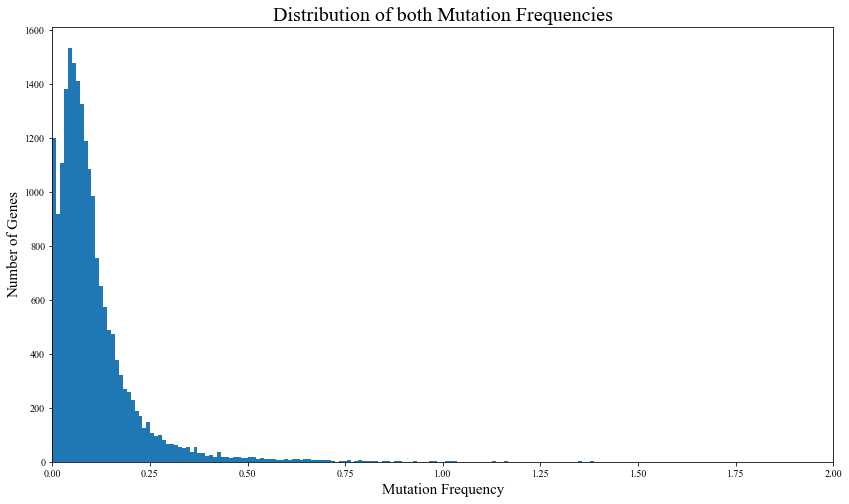

In [63]:
ax = mean_mut_freqs.sum(axis=1).plot(kind='hist', bins=np.linspace(0, 2, 200), figsize=(14, 8))
plt.xlim([0, 2])
ax.set_ylabel('Number of Genes', fontsize=15)
ax.set_title('Distribution of both Mutation Frequencies', fontsize=20)
ax.set_xlabel('Mutation Frequency', fontsize=15)

## Write a HDF container with the "raw" mutation frequencies
In the HDF5 container, I want to write the following:

* $Gene \times Sample$ matrix (for both, CNAs and SNVs)
* CNA matrix ($Gene \times Samples$)
* SNV matrix ($Gene \times Samples$)

In [65]:
fname = '../../data/pancancer/TCGA/mutation/mutation_frequencies_{}.h5'.format('lengthnormalized' if NORMALIZE_FOR_GENE_LENGTH else 'raw')
snv_gene_sample_matrix.to_hdf(fname, 'snv_sample_matrix', mode='a')
final_cna_matrix.to_hdf(fname, 'cna_sample_matrix', mode='a')
cna_snv_sample_mat.to_hdf(fname, 'snv_cna_sample_matrix', mode='a')
print ("Raw information written to {}".format(fname))

Raw information written to ../../data/pancancer/TCGA/mutation/mutation_frequencies_lengthnormalized.h5


## T-SNE plot of the data

In [66]:
mut_sample_mat = matrix_with_cancer_types.set_index('Cancer_Type')
embedding = umap.UMAP().fit_transform(mut_sample_mat.drop(['Cancer_Type'], axis=1, errors='ignore'))

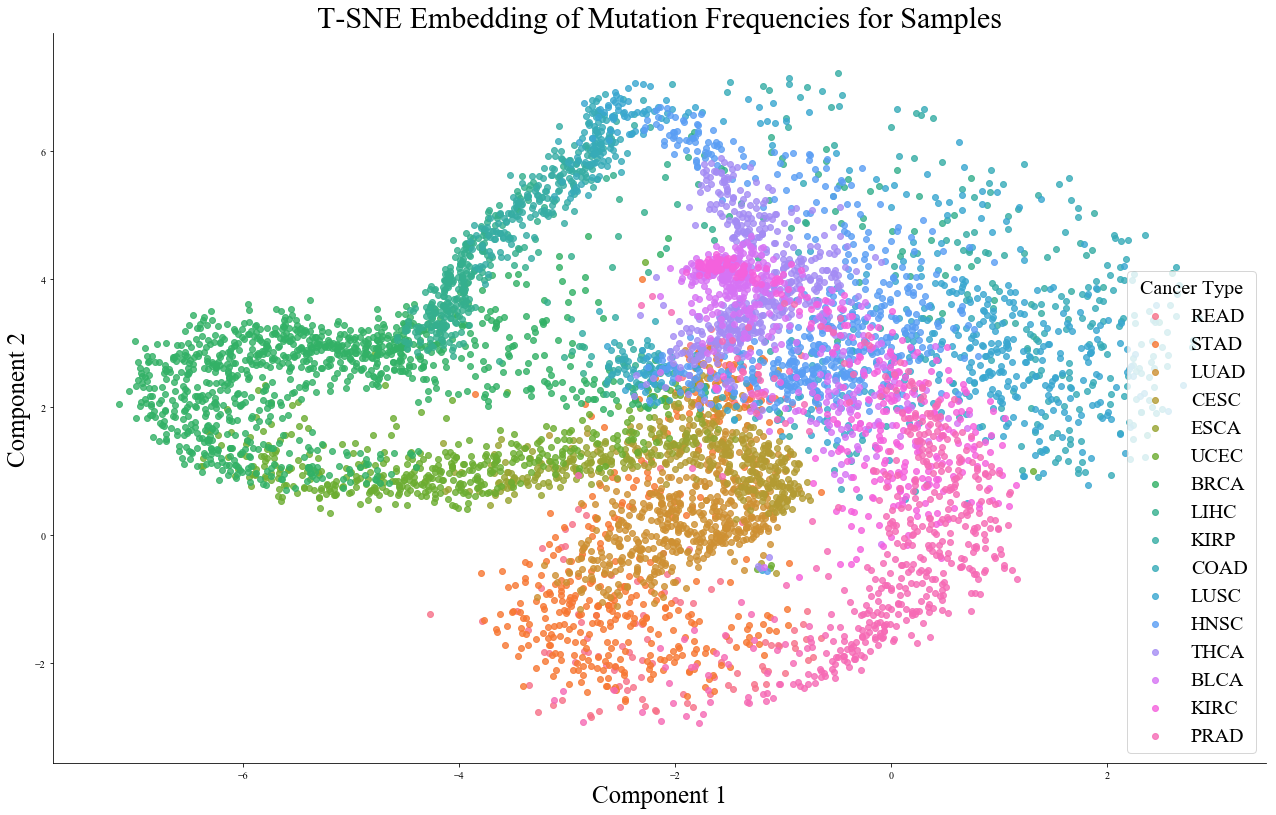

In [67]:
long = pd.DataFrame(embedding, columns=['pc1', 'pc2'], index=mut_sample_mat.index)
cancer_type = [i.split('-')[1] for i in mut_sample_mat.index]
long['cancertype'] = cancer_type
g = sns.lmplot(x='pc1', y='pc2', data=long, hue='cancertype', fit_reg=False, legend=False)
g.fig.set_size_inches(20, 12)
g.ax.set_xlabel('Component 1', fontsize=25)
g.ax.set_ylabel('Component 2', fontsize=25)
g.ax.legend(loc='lower right', fontsize=20, title='Cancer Type')
plt.setp(g.ax.get_legend().get_title(), fontsize=20)
plt.title('T-SNE Embedding of Mutation Frequencies for Samples', fontsize=30)
g.fig.savefig('../../data/pancancer/TCGA/mutation/tsne_tumortypes.png', dpi=300)